In [79]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.optimizers import RMSprop, adam
from keras.utils.data_utils import get_file
from keras.callbacks import History, ModelCheckpoint
import numpy as np
import pandas as pd
import random
import sys
import string
import matplotlib.pyplot as plt
%matplotlib inline

# Define number of inputs/outputs to handle
input_size = 16
output_size = 16

# Load the train data
#path = "???.csv"
#df = pd.read_csv(path)

df = np.ones((100,16,2),dtype=int)

print('Train total outputs:', output)

# Pre-process the data (normalize)

# cut the input in semi-redundant sequences of maxlen characters
maxlen = 60
step_days = 3
max_sequences = 10**3
days_sequence = np.empty((max_sequences,maxlen,input_size),dtype=int)
next_day = np.empty((max_sequences,output_size),dtype=int)

j=0
for woman_i in range(0,df.shape[2]):
    for day_i in range(0, df.shape[0] - maxlen, step_days):
        days_sequence[j] = df[day_i: day_i + maxlen,:input,woman_i]
        next_day[j] = df[day_i + maxlen,:input,woman_i]
        j += 1

print('Train nb sequences:', len(days_sequence))

X_train=days_sequence
y_train=next_day

X_test=days_sequence[:10,:,:]
y_test=next_day[:10,:]

Train total outputs: 16
Train nb sequences: 1000


In [140]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1000, 60, 16)
(1000, 16)
(10, 60, 16)
(10, 16)


In [180]:
def plot_logs(history):
    """
    Plot the accuracy and loss for 
        training and test sets
    """
    evaluation_cost = history.history['val_loss']
    evaluation_accuracy = history.history['val_acc']
    training_cost = history.history['loss']
    training_accuracy = history.history['acc']
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    ax1.plot(evaluation_cost,label= 'test')
    ax1.plot(training_cost, label='train')
    ax1.set_title('Cost')
    ax1.legend()
    ax2.plot(evaluation_accuracy, label='test')
    ax2.plot(training_accuracy, label='train')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')


def sample(preds, temperature=1.0):
    """
    Generate the next sequence
    Low temperature means very conservative (picks more probable most of the time)
    High temperature means very adventurous (picks less probable more frequently)
    """
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_prediction(history,days=28, maxlen=60, input_size=16, output_size=16, diversity=1):
    """
    Generates as many days of prediction as requested
    Considers maxlen days of past history (must be aligned with model)
    """
    generated = np.zeros((days,output_size))
    if history.shape[1]>60:
        x = history[:,-61:-1,:input_size]
    else:
        x = history[:,:,:input_size]
    #print(x.shape)
    for i in range(days):
        #print("Day %d" % i)
        preds = model.predict(x, verbose=0)[0]
        #print(preds)
        #next_symptoms = sample(preds, diversity)
        next_symptoms = preds
        #print(next_symptoms)

        generated[i,:] = next_symptoms
        x[:,:maxlen-1,:] = x[:,1:,:]
        x[:,maxlen-1,:] = next_symptoms

    return generated

In [181]:
res = generate_prediction(X_train[0,:,:].reshape(1,60,-1))
res.shape

(28, 16)

Build model...
Train on 1000 samples, validate on 10 samples
Epoch 1/10
1000/1000 [==============================] - 2s - loss: 2371375736.8320 - acc: 0.0120 - val_loss: 2.7747 - val_acc: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 0s - loss: 2371036475.3920 - acc: 0.0120 - val_loss: 2.7741 - val_acc: 0.0000e+00
Epoch 3/10
1000/1000 [==============================] - 0s - loss: 2370814969.8560 - acc: 0.0120 - val_loss: 2.7733 - val_acc: 0.0000e+00
Epoch 4/10
1000/1000 [==============================] - 0s - loss: 2370760257.5360 - acc: 0.0120 - val_loss: 2.7729 - val_acc: 0.0000e+00
Epoch 5/10
1000/1000 [==============================] - 0s - loss: 2370730737.6640 - acc: 0.0120 - val_loss: 2.7728 - val_acc: 0.0000e+00
Epoch 6/10
1000/1000 [==============================] - 0s - loss: 2370809034.7520 - acc: 0.0120 - val_loss: 2.7727 - val_acc: 0.0000e+00
Epoch 7/10
1000/1000 [==============================] - 0s - loss: 2370690273.2800 - acc: 0.0120 - val_loss: 2.

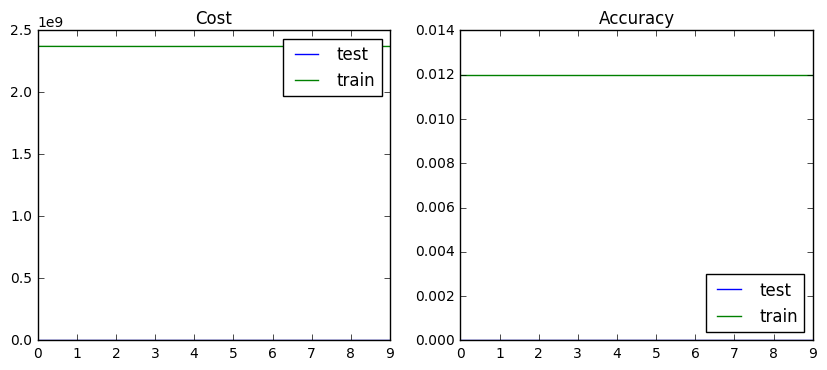

In [85]:
# Model params
batch_size = 128
nb_epoch = 10
np.random.seed(131078)

# build the model
print('Build model...')

filepath="lstm_1_layer.hdf5"
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, input_size)))
model.add(Dense(output_size))
model.add(Activation('softmax'))

"""
filepath="lstm_2_layers.hdf5"
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, output, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
"""


optimizer = adam()
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

# Define callback to save model
save_snapshots = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='max',
                                 verbose=1)
callbacks_list = [save_snapshots]

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1)          

score = model.evaluate(X_test, y_test, verbose=2)
print('Test score:', score[0])
print('Test accuracy:', score[1])  

plot_logs(history)          
